<a href="https://colab.research.google.com/github/rinrin528/AIFFEL-1st-Hackathon/blob/main/EDA/%EC%BA%90%EA%B8%80%ED%95%B4%EC%BB%A4%ED%86%A4_%EC%A0%84%EC%B2%98%EB%A6%AC%EC%BD%94%EB%93%9C%EC%A0%95%EB%A6%AC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import time, datetime
from sklearn import preprocessing
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import MinMaxScaler, StandardScaler ,RobustScaler

import warnings
warnings.filterwarnings("ignore")

# **파일 불러오기**

In [ ]:
path='/content/gdrive/MyDrive/AIFFEL/해커톤 1/recruit-restaurant-visitor-forecasting/'

In [ ]:
data = {
    'tra': pd.read_csv(path+'air_visit_data.csv.zip'),
    'as': pd.read_csv(path+'air_store_info.csv.zip'),
    'hs': pd.read_csv(path+'hpg_store_info.csv.zip'),
    'ar': pd.read_csv(path+'air_reserve.csv.zip'),
    'hr': pd.read_csv(path+'hpg_reserve.csv.zip'),
    'id': pd.read_csv(path+'store_id_relation.csv.zip'),
    'tes': pd.read_csv(path+'sample_submission.csv.zip'),
    'hol': pd.read_csv(path+'date_info.csv.zip').rename(columns={'calendar_date':'visit_date'})
    }

#  **데이터 확인하기**

##### **tra** : air restaurants의 과거 방문 data, main training data set (air_visit_data.csv)
* 총 데이터 수 : 252108개
* 방문기록이 있는 air_store_id : 829개


In [ ]:
data['tra'].head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


##### **as** : air 레스토랑 세부 정보 (air_store_info.csv)
* air 레스토랑 세부 정보가 존재하는 식당 수   : 829개

In [ ]:
data['as'].head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


##### **hs** : hpg 레스토랑 세부 정보 (hpg_store_info.csv)
* * hpg 레스토랑 세부 정보가 존재하는 식당 수   : 4690개

In [ ]:
data['hs'].head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


##### **ar** : air 레스토랑 예약 시스템 (air_reserve.csv)
* 총 데이터 수 : 92378개
* air 예약된 식당 수 : 314개

In [ ]:
data['ar'].head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


##### **hr** : hpg 레스토랑 예약 시스템 (hpg_reserve.csv)
* 총 데이터 수 : 2000320개
* hpg 예약된 식당 수 : 13325개

In [ ]:
data['hr'].head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


##### **id** : 동일한 가게에 대한 air & hpg id (store_id_relation.csv)
* 총 데이터 수 : 150개

In [ ]:
data['id'].head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


##### **hol** : 일본 공휴일 정보 (date_info.csv)
* 2016/01/01 ~ 2017/05/31 기간동안의 공휴일 정보
* 데이터를 합칠 때를 위해 calendar_date를 visit_date로 컬럼명을 변경하였음

In [ ]:
data['hol'].head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


##### **tes** : test set으로 사용. (sample_submission.csv)
* ’id’는 air id와 방문 날짜를 결합하여 생성

In [ ]:
data['tes'].head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


##### 데이터 정리

In [ ]:
print('[----Data structure----]')
print('Training data:\t\t',data['tra'].shape, '\tunique store id: ',len(data['tra']['air_store_id'].unique()))
print('Id data:\t\t',data['id'].shape)
print('Air store data:\t\t',data['as'].shape,'\tunique store id: ',data['as']['air_store_id'].unique().shape)
print('Hpg store data:\t\t',data['hs'].shape,'\tunique store id: ',data['hs']['hpg_store_id'].unique().shape)
print('Air reserve data:\t',data['ar'].shape,'\tunique store id: ',data['ar']['air_store_id'].unique().shape)
print('Hpg reserve data:\t',data['hr'].shape,'\tunique store id: ',data['hr']['hpg_store_id'].unique().shape)

[----Data structure----]
Training data:		 (252108, 3) 	unique store id:  829
Id data:		 (150, 2)
Air store data:		 (829, 5) 	unique store id:  (829,)
Hpg store data:		 (4690, 5) 	unique store id:  (4690,)
Air reserve data:	 (92378, 4) 	unique store id:  (314,)
Hpg reserve data:	 (2000320, 4) 	unique store id:  (13325,)


# **전처리하기**

##### 이상치 제거 (실제 방문객 수 중 450명을 넘으면 제거)


In [ ]:
data['tra']= data['tra'][data['tra']['visitors']<450]

In [ ]:
data['tra'].loc[data['tra']['visitors']>400] # 제거완료

,air_store_id,visit_date,visitors
167504,air_9828505fefc77d75,2016-11-19,409


##### air와 hpg에 둘 다 있는 가게는 150개밖에 없다 (= store_id_relation데이터의 크기) 
##### 따라서 air와 겹치는 hpg의 데이터만 가져와서 사용하기로 정하였다.

In [ ]:
# hpg 예약정보에 id 파일에서  hpg_store_id와 일치하는 air_store_id 정보를 추가함
data['hr'] = pd.merge(data['hr'], data['id'], how='inner', on=['hpg_store_id'])
data['hr'].head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors,air_store_id
0,hpg_878cc70b1abc76f7,2016-01-01 19:00:00,2016-01-01 15:00:00,4,air_db80363d35f10926
1,hpg_878cc70b1abc76f7,2016-01-02 19:00:00,2016-01-02 14:00:00,2,air_db80363d35f10926
2,hpg_878cc70b1abc76f7,2016-01-03 18:00:00,2016-01-02 20:00:00,6,air_db80363d35f10926
3,hpg_878cc70b1abc76f7,2016-01-06 20:00:00,2016-01-04 22:00:00,3,air_db80363d35f10926
4,hpg_878cc70b1abc76f7,2016-01-11 18:00:00,2016-01-11 14:00:00,2,air_db80363d35f10926


##### air, hpg reservation 데이터
* air_store_id 기준으로 보기
* reserve_datetime_diff 컬럼 생성 : 예약을 진행한 날짜와 실제 방문할 날짜의 차이 => 며칠 전에 예약을 하는가?
* visit_datetime(날짜 + 시간) 형태에서 visit_date(날짜) 형태로 바꿈 
* 같은 날짜 다른 시간의 reserve_visitors 정보도 같은 날짜의 reserve_visitors로 합쳐짐.


In [ ]:
for df in ['ar', 'hr']:
    data[df]['visit_datetime'] = pd.to_datetime(data[df]['visit_datetime']) # 데이터타입을 datatime으로 변경
    data[df]['visit_datetime'] = data[df]['visit_datetime'].dt.date # YYYY-MM-DD(문자) 형식으로 바꿈
    data[df]['reserve_datetime'] = pd.to_datetime(data[df]['reserve_datetime']) 
    data[df]['reserve_datetime'] = data[df]['reserve_datetime'].dt.date
    data[df]['reserve_datetime_diff'] = data[df].apply(
        lambda r: (r['visit_datetime'] - r['reserve_datetime']).days, axis=1) 
    data[df] = data[df].groupby(
        ['air_store_id', 'visit_datetime'], as_index=False)[[
            'reserve_datetime_diff', 'reserve_visitors'  
        ]].sum().rename(columns={
            'visit_datetime': 'visit_date'    # visit_datetime 에서 visit_date로 컬럼명 변경
        })
    print(data[df].head())

           air_store_id  visit_date  reserve_datetime_diff  reserve_visitors
0  air_00a91d42b08b08d9  2016-10-31                      0                 2
1  air_00a91d42b08b08d9  2016-12-05                      4                 9
2  air_00a91d42b08b08d9  2016-12-14                      6                18
3  air_00a91d42b08b08d9  2016-12-17                      6                 2
4  air_00a91d42b08b08d9  2016-12-20                      2                 4
           air_store_id  visit_date  reserve_datetime_diff  reserve_visitors
0  air_00a91d42b08b08d9  2016-01-14                      3                 2
1  air_00a91d42b08b08d9  2016-01-15                      6                 4
2  air_00a91d42b08b08d9  2016-01-16                      3                 2
3  air_00a91d42b08b08d9  2016-01-22                      3                 2
4  air_00a91d42b08b08d9  2016-01-29                      6                 5


##### tra : air 레스토랑 실제 방문날짜와 방문객수 전처리
* visit_date 컬럼에서 파생변수 만들기
* 날짜를 '년-월-일'의 형태로 변환한다.
* 요일 인덱스값, 연도, 월  feature를 추가한다.


In [ ]:
data['tra'].head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [ ]:
data['tra']['visit_date'] = pd.to_datetime(data['tra']['visit_date']) # 날짜 데이터타입으로 변경
data['tra']['dow'] = data['tra']['visit_date'].dt.dayofweek           # 요일 컬럼 생성(정수 0~6)
data['tra']['year'] = data['tra']['visit_date'].dt.year               # 년도 컬럼 생성
data['tra']['month'] = data['tra']['visit_date'].dt.month             # month 컬럼 생성
data['tra']['visit_date'] = data['tra']['visit_date'].dt.date         # YYYY-MM-DD(문자) 형태로 변경
data['tra'].head()

,air_store_id,visit_date,visitors,dow,year,month
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1


##### tes : submission 데이터 전처리 
* id 컬럼 (air_store_id + visit_date) 로 분리하기
> 데이터 예시: <br>
'id'칼럼
  - air_00a91d42b08b08d9_2017-04-23	
  - air_00a91d42b08b08d9_2017-04-24
  - air_00a91d42b08b08d9_2017-04-25

따라서 split('\_')을 했을 때 인덱스2인 원소가 날짜에 해당한다.<br>
👉 'visit_date'칼럼 생성

<br>

split('\_')을 했을 때 인덱스0,1인 원소를 다시 '\_'로 붙이면 air id가 된다.<br>
👉 'air_store_id'칼럼 생성

* visit_date에서 파생변수 만들기

In [ ]:
data['tes'].head()

,id,visitors
0,air_00a91d42b08b08d9_2017-04-23,0
1,air_00a91d42b08b08d9_2017-04-24,0
2,air_00a91d42b08b08d9_2017-04-25,0
3,air_00a91d42b08b08d9_2017-04-26,0
4,air_00a91d42b08b08d9_2017-04-27,0


In [ ]:
data['tes']['visit_date'] = data['tes']['id'].map(
    lambda x: str(x).split('_')[2])                                   # visit_date 방문날짜 컬럼 만들기
data['tes']['air_store_id'] = data['tes']['id'].map(
    lambda x: '_'.join(x.split('_')[:2]))                             # id 컬럼 만들기
data['tes']['visit_date'] = pd.to_datetime(data['tes']['visit_date']) # 날짜 데이터형식으로 변형
data['tes']['dow'] = data['tes']['visit_date'].dt.dayofweek           # 요일 : 0~6
data['tes']['year'] = data['tes']['visit_date'].dt.year
data['tes']['month'] = data['tes']['visit_date'].dt.month
data['tes']['visit_date'] = data['tes']['visit_date'].dt.date
data['tes'].head()

,id,visitors,visit_date,air_store_id,dow,year,month
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4


##### submission파일에서 air_store_id 유일한 값들만 찾기
=> test데이터셋에 등장하는 가게는 총 821개이다

In [ ]:
unique_stores = data['tes']['air_store_id'].unique() 
len(unique_stores)

821

##### 'stores' 데이터프레임 생성 
* submission에 있던 가게들('air_store_id')과 이 가게들이 각 요일마다 방문객 수가 어떤지를 보려고 만든 데이터프레임


In [ ]:
stores = pd.concat(
    [
        pd.DataFrame({
            'air_store_id': unique_stores, # submission의 air_store_id 유일값들
            'dow': [i] * len(unique_stores)
        }) for i in range(7) # 요일 0~6
    ],
    axis=0,
    ignore_index=True).reset_index(drop=True)

In [ ]:
stores.info() # 총 5747개의 데이터 = 821개의 가게 * 요일 7개 (0~6)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5747 entries, 0 to 5746
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   air_store_id  5747 non-null   object
 1   dow           5747 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 89.9+ KB


In [ ]:
stores.head()

,air_store_id,dow
0,air_00a91d42b08b08d9,0
1,air_0164b9927d20bcc3,0
2,air_0241aa3964b7f861,0
3,air_0328696196e46f18,0
4,air_034a3d5b40d5b1b1,0


##### store 데이터프레임에 'air_store_id', 'dow' 기준으로 실제 방문자 수에 대하여 최솟값, 평균값, 중앙값, 최댓값, count를 계산하고 새로운 feature로 추가한다.

In [ ]:
# 최소 방문객 수
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].min().rename(columns={
        'visitors': 'min_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

In [ ]:
# 평균 방문객 수
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].mean().rename(columns={
        'visitors': 'mean_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

In [ ]:
# 중앙값 방문객 수
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].median().rename(columns={
        'visitors': 'median_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])


In [ ]:
# 최대 방문객 수
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].max().rename(columns={
        'visitors': 'max_visitors'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])

In [ ]:
# 'air_store_id', 'dow' 기준으로 몇번 방문했나? 
# 예) a라는 레스토랑에 토요일에 방문한 데이터가 몇개인가?
tmp = data['tra'].groupby(
    ['air_store_id', 'dow'],
    as_index=False)['visitors'].count().rename(columns={
        'visitors': 'count_observations'
    })
stores = pd.merge(stores, tmp, how='left', on=['air_store_id', 'dow'])
stores.head()

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0


In [ ]:
#  58개의 null 값 존재 => 실제 방문 내역에 (특정 가게,특정요일) 조합이 58개가 없는 것 같다.
stores.isnull().sum()

air_store_id           0
dow                    0
min_visitors          58
mean_visitors         58
median_visitors       58
max_visitors          58
count_observations    58
dtype: int64

#####  store 데이터 프레임의 air_store_id와 일치하는 가게 정보(레스토랑 종류, 위치정보)만 가져와서 컬럼 추가 (hpg_store_info는 활용하지 않음)

In [ ]:
stores = pd.merge(stores, data['as'], how='left', on=['air_store_id']) 
stores.head()

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,Italian/French,Tōkyō-to Chiyoda-ku Kudanminami,35.694003,139.753595
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0,Izakaya,Tōkyō-to Taitō-ku Higashiueno,35.712607,139.779996
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0,Dining bar,Ōsaka-fu Ōsaka-shi Nakanochō,34.701279,135.528090
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0,Cafe/Sweets,Ōsaka-fu Ōsaka-shi Ōhiraki,34.692337,135.472229


##### air_genre_name,	air_area_name 라벨인코딩하기

In [ ]:
lbl = preprocessing.LabelEncoder() # 라벨인코더 

In [ ]:
stores['air_genre_name'] = lbl.fit_transform(stores['air_genre_name']) # 레스토랑 종류를 정수로 변환하여 저장한다.
stores['air_area_name'] = lbl.fit_transform(stores['air_area_name'])   # 지역 이름을 정수로 변환하여 저장한다.
stores.head()

,air_store_id,dow,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9,0,1.0,22.457143,19.0,47.0,35.0,6,44,35.694003,139.753595
1,air_0164b9927d20bcc3,0,2.0,7.500000,6.0,19.0,20.0,6,62,35.658068,139.751599
2,air_0241aa3964b7f861,0,2.0,8.920635,8.0,23.0,63.0,7,82,35.712607,139.779996
3,air_0328696196e46f18,0,2.0,6.416667,4.0,27.0,12.0,4,98,34.701279,135.528090
4,air_034a3d5b40d5b1b1,0,1.0,11.864865,10.0,66.0,37.0,2,102,34.692337,135.472229


##### hol 전처리 : date_info 데이터에서 날짜, 요일을 이전과정과 같이 처리한다.
* 컬럼명 변경된 상태 'calendar_date'->'visit_date'
* 날짜 => 연,월,일만 저장
* 요일 라벨인코딩하기 (정수 0~6 으로 변환)

In [ ]:
data['hol'].head()

,visit_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


In [ ]:
data['hol']['visit_date'] = pd.to_datetime(data['hol']['visit_date'])      # 날짜 데이터 타입으로 변경
data['hol']['day_of_week'] = lbl.fit_transform(data['hol']['day_of_week']) # 요일 : 문자 -> 숫자(0~6)
data['hol']['visit_date'] = data['hol']['visit_date'].dt.date
data['hol'].head()


,visit_date,day_of_week,holiday_flg
0,2016-01-01,0,1
1,2016-01-02,2,1
2,2016-01-03,3,1
3,2016-01-04,1,0
4,2016-01-05,5,0


# **데이터 합치기** => train, test set 

In [ ]:
data['tra'].head(2)

,air_store_id,visit_date,visitors,dow,year,month
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1


In [ ]:
data['hol'].head(2)

,visit_date,day_of_week,holiday_flg
0,2016-01-01,0,1
1,2016-01-02,2,1


In [ ]:
# 위의 두 데이터프레임을 visit_date 기준으로 합치기
train = pd.merge(data['tra'], data['hol'], how='left', on=['visit_date']) 
train.head()

,air_store_id,visit_date,visitors,dow,year,month,day_of_week,holiday_flg
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,6,0
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,4,0
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,0,0
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,2,0
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,1,0


In [ ]:
# test set도 같은 방식으로 합침
test = pd.merge(data['tes'], data['hol'], how='left', on=['visit_date'])
test.head()

,id,visitors,visit_date,air_store_id,dow,year,month,day_of_week,holiday_flg
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4,3,0
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4,1,0
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4,5,0
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4,6,0
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4,4,0


##### stores 데이터프레임을 train,test set에 추가하기

In [ ]:
#아이디와 요일기준으로 합치기
train = pd.merge(train, stores, how='left', on=['air_store_id', 'dow']) 
train.head()

,air_store_id,visit_date,visitors,dow,year,month,day_of_week,holiday_flg,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,6,0,7.0,23.843750,25.0,57.0,64.0,4.0,62.0,35.658068,139.751599
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,4,0,2.0,20.292308,21.0,54.0,65.0,4.0,62.0,35.658068,139.751599
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,0,0,4.0,34.738462,35.0,61.0,65.0,4.0,62.0,35.658068,139.751599
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,2,0,6.0,27.651515,27.0,53.0,66.0,4.0,62.0,35.658068,139.751599
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,1,0,2.0,13.754386,12.0,34.0,57.0,4.0,62.0,35.658068,139.751599


In [ ]:
# test set도 동일한 방식으로 합침
test = pd.merge(test, stores, how='left', on=['air_store_id', 'dow'])
test.head()

,id,visitors,visit_date,air_store_id,dow,year,month,day_of_week,holiday_flg,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude
0,air_00a91d42b08b08d9_2017-04-23,0,2017-04-23,air_00a91d42b08b08d9,6,2017,4,3,0,2.0,2.000000,2.0,2.0,1.0,6,44,35.694003,139.753595
1,air_00a91d42b08b08d9_2017-04-24,0,2017-04-24,air_00a91d42b08b08d9,0,2017,4,1,0,1.0,22.457143,19.0,47.0,35.0,6,44,35.694003,139.753595
2,air_00a91d42b08b08d9_2017-04-25,0,2017-04-25,air_00a91d42b08b08d9,1,2017,4,5,0,1.0,24.350000,24.5,43.0,40.0,6,44,35.694003,139.753595
3,air_00a91d42b08b08d9_2017-04-26,0,2017-04-26,air_00a91d42b08b08d9,2,2017,4,6,0,15.0,28.125000,28.0,52.0,40.0,6,44,35.694003,139.753595
4,air_00a91d42b08b08d9_2017-04-27,0,2017-04-27,air_00a91d42b08b08d9,3,2017,4,4,0,15.0,29.868421,30.0,47.0,38.0,6,44,35.694003,139.753595


##### train,test set에 air_store_id와 visit_date기준으로 reservation_diff랑 예약손님 수 컬럼 넣기

In [ ]:
for df in ['ar', 'hr']:
    train = pd.merge(
        train, data[df], how='left', on=['air_store_id', 'visit_date'])
    test = pd.merge(
        test, data[df], how='left', on=['air_store_id', 'visit_date'])

In [ ]:
train.head(3)

,air_store_id,visit_date,visitors,dow,year,month,day_of_week,holiday_flg,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,6,0,7.0,23.843750,25.0,57.0,64.0,4.0,62.0,35.658068,139.751599,NaN,NaN,NaN,NaN
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,4,0,2.0,20.292308,21.0,54.0,65.0,4.0,62.0,35.658068,139.751599,NaN,NaN,NaN,NaN
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,0,0,4.0,34.738462,35.0,61.0,65.0,4.0,62.0,35.658068,139.751599,NaN,NaN,NaN,NaN


In [ ]:
# train과 test데이터 모두 결측치는 -1로 채운다.
train = train.fillna(-1)
test = test.fillna(-1)

In [ ]:
train.head()

,air_store_id,visit_date,visitors,dow,year,month,day_of_week,holiday_flg,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,6,0,7.0,23.843750,25.0,57.0,64.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,4,0,2.0,20.292308,21.0,54.0,65.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,0,0,4.0,34.738462,35.0,61.0,65.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
3,air_ba937bf13d40fb24,2016-01-16,22,5,2016,1,2,0,6.0,27.651515,27.0,53.0,66.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0
4,air_ba937bf13d40fb24,2016-01-18,6,0,2016,1,1,0,2.0,13.754386,12.0,34.0,57.0,4.0,62.0,35.658068,139.751599,-1.0,-1.0,-1.0,-1.0


##### Binding to float32

In [ ]:
for c, dtype in zip(train.columns, train.dtypes):
    if dtype == np.float64:
        train[c] = train[c].astype(np.float32)

for c, dtype in zip(test.columns, test.dtypes):
    if dtype == np.float64:
        test[c] = test[c].astype(np.float32)

##### weather 데이터 추가

In [ ]:
# datetime 데이터 타입으로 변경
train.visit_date = pd.to_datetime(train.visit_date)
test.visit_date = pd.to_datetime(test.visit_date)

In [ ]:
def add_weather(dataset):                                                                                                                     
    print('Adding weather...')                                                                                                                
    air_nearest = pd.read_csv(                                                                                                                
        '/content/gdrive/MyDrive/AIFFEL/해커톤 1/recruit-restaurant-visitor-forecasting/air_store_info_with_nearest_active_station.csv')                                                              
    unique_air_store_ids = list(dataset.air_store_id.unique())                                                                                
                                                                                                                                              
    weather_dir = '/content/gdrive/MyDrive/AIFFEL/해커톤 1/recruit-restaurant-visitor-forecasting/1-1-16_5-31-17_Weather/'                                                                         
    weather_keep_columns = ['precipitation', 'avg_temperature'] # 강수량, 평균 온도 데이터                                                                                                                                
                                                                                                                                              
    dataset_with_weather = dataset.copy()                                                                                                     
    for column in weather_keep_columns:                                                                                                       
        dataset_with_weather[column] = np.nan                                                                                                 
                                                                                                                                              
    for air_id in unique_air_store_ids:                                                                                                       
        station = air_nearest[air_nearest.air_store_id == air_id].station_id.iloc[0]                                                          
        weather_data = pd.read_csv(weather_dir + station + '.csv', parse_dates=['calendar_date']).rename(columns={'calendar_date': 'visit_date'})                                                                                                                                           
                                                                                                                                              
        this_store = dataset.air_store_id == air_id                                                                                           
        merged = dataset[this_store].merge(weather_data, on='visit_date', how='left')                                                         
                                                                                                                                              
        for column in weather_keep_columns:                                                                                                   
            dataset_with_weather.loc[this_store, column] = merged[column]                                                                     
    return dataset_with_weather                                                                                                               
# 컬럼 추가                                                                                                                                             
train = add_weather(train)                                                                                                                    
test = add_weather(test)  

Adding weather...
Adding weather...


In [ ]:
# train set 확인
train.head(3)

,air_store_id,visit_date,visitors,dow,year,month,day_of_week,holiday_flg,min_visitors,mean_visitors,median_visitors,max_visitors,count_observations,air_genre_name,air_area_name,latitude,longitude,reserve_datetime_diff_x,reserve_visitors_x,reserve_datetime_diff_y,reserve_visitors_y,precipitation,avg_temperature
0,air_ba937bf13d40fb24,2016-01-13,25,2,2016,1,6,0,7.0,23.843750,25.0,57.0,64.0,4.0,62.0,35.65807,139.751602,-1.0,-1.0,-1.0,-1.0,NaN,4.3
1,air_ba937bf13d40fb24,2016-01-14,32,3,2016,1,4,0,2.0,20.292307,21.0,54.0,65.0,4.0,62.0,35.65807,139.751602,-1.0,-1.0,-1.0,-1.0,NaN,6.0
2,air_ba937bf13d40fb24,2016-01-15,29,4,2016,1,0,0,4.0,34.738461,35.0,61.0,65.0,4.0,62.0,35.65807,139.751602,-1.0,-1.0,-1.0,-1.0,0.0,5.6


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 252103 entries, 0 to 252102
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   air_store_id             252103 non-null  object        
 1   visit_date               252103 non-null  datetime64[ns]
 2   visitors                 252103 non-null  int64         
 3   dow                      252103 non-null  int64         
 4   year                     252103 non-null  int64         
 5   month                    252103 non-null  int64         
 6   day_of_week              252103 non-null  int64         
 7   holiday_flg              252103 non-null  int64         
 8   min_visitors             252103 non-null  float32       
 9   mean_visitors            252103 non-null  float32       
 10  median_visitors          252103 non-null  float32       
 11  max_visitors             252103 non-null  float32       
 12  count_observatio

##### train_x,train_y, test_x 

In [ ]:
train_x = train.drop(['air_store_id', 'visit_date', 'visitors'], axis=1)
train_y = np.log1p(train['visitors'].values) # target값 로그변환시켜 정규화
print(train_x.shape, train_y.shape)
test_x = test.drop(['id', 'air_store_id', 'visit_date', 'visitors'], axis=1)

(252103, 20) (252103,)


# **모델 생성 및 학습**

In [ ]:
# parameter tuning of lightgbm
# start from default setting
gbm0 = lgb.LGBMRegressor(
    objective='regression',
    num_leaves=60,
    learning_rate=0.01,
    n_estimators=10000,random_state=0)
gbm0.fit(train_x, train_y, eval_metric='rmse')

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.01, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=10000, n_jobs=-1, num_leaves=60,
              objective='regression', random_state=0, reg_alpha=0.0,
              reg_lambda=0.0, silent=True, subsample=1.0,
              subsample_for_bin=200000, subsample_freq=0)

# **예측 및 제출 파일 생성**

In [ ]:
predict_y = gbm0.predict(test_x)
test['visitors'] = np.expm1(predict_y)
test[['id', 'visitors']].to_csv(
    'gbm0_submission_outlier450.csv', index=False, float_format='%.3f') 

# 회고

1) air_visit_data에서 visitors의 최댓값이 877명이었다. <br>
휴일도 아니었고 골든위크도 아닌데 왜 이렇게 많았던 것일까? 심지어 평소엔 많이 와도 20명정도인 가게였다. => 이상치라고 생각!
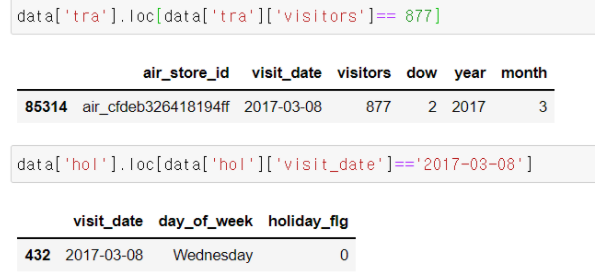 <br>
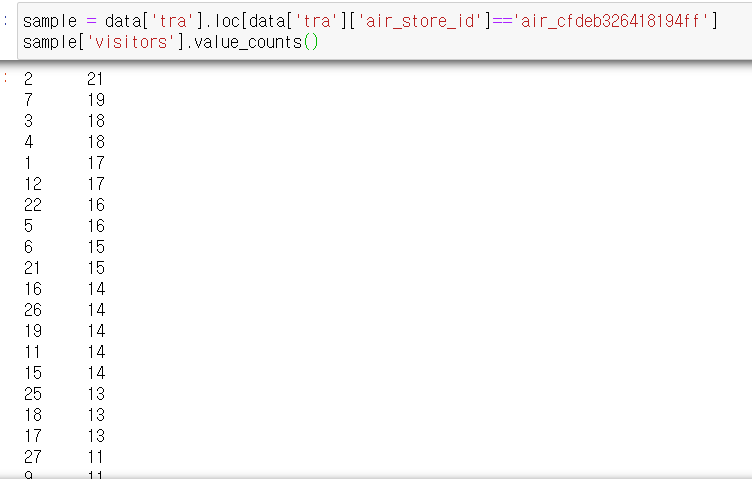


2) 노쇼 데이터<br>
노쇼를 한건지에 대해 알 수 있을까 궁금하여 air예약정보 데이터와 실제 방문 데이터를 합쳤다. <br>
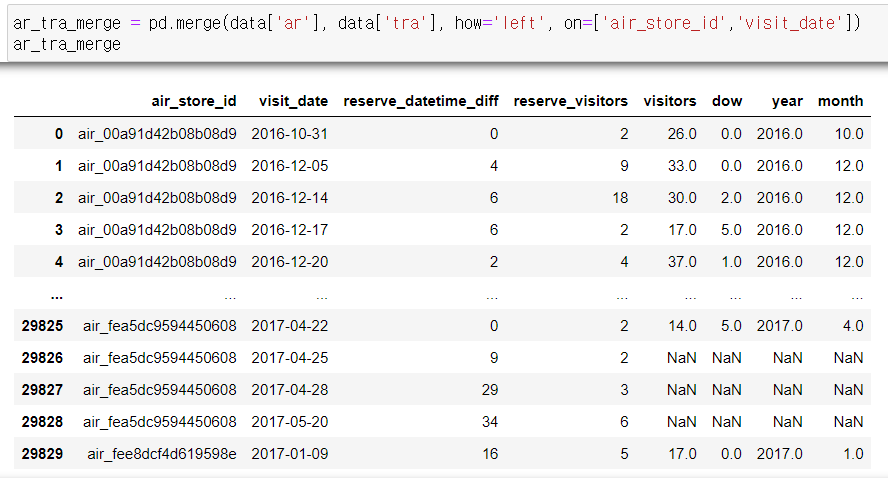 <br>
air 예약 정보의 air_store_id 기준으로 합쳤더니 실제 방문자 수 관련 컬럼에 NaN 값(visitors 컬럼에서 1766개의 null값)이 존재했다. <br>
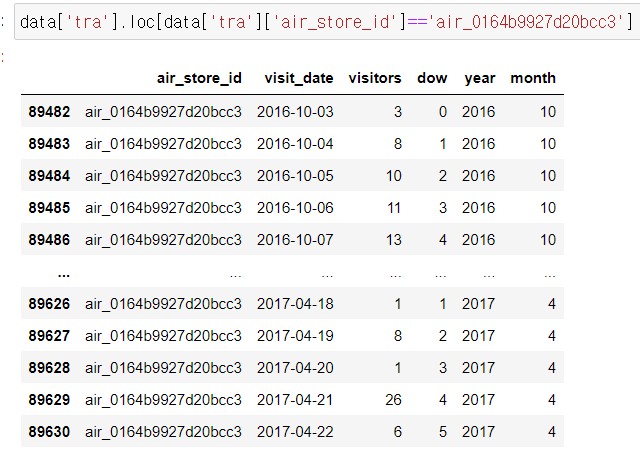 <br>
null 값을 가진 데이터의 air_store_id와 관련된 데이터를 air_visit_data에서 찾아보면 2017년 4월 23일부터 visit 데이터가 존재하지 않는다. 폐업한걸까? 아니면 그냥 방문자 기록을 안 한걸까? 노쇼를 했는데 기록이 안 된것일까? <br>
=> 한 가게의 예약한 날짜의 손님수와 그날 실제 방문한 손님수 비교를 하면 노쇼데이터를 알 수 있을거 같았지만 예약을 안 하고 방문한 손님이 더 많을시엔 비교가 불가능하다고 생각했다.


3) 날씨데이터 <br>
날씨데이터를 가져오는 코드가 적힌 커널을 참고하였다. 거의다 Nan 값이여서 결측치를 어떻게 채워야되나 고민하였다. 평균넣기, 결측치 바로 이전의 값으로 채우기(method='pad) 등의 방법을 써봤지만 그냥 NaN 그대로 학습 시켰을 때가 점수가 가장 좋았다. 결측치를 어떻게 처리해야될까?